# Pythonを使って心拍解析を行う


## 用語
* BPM(Beat Per Minute): 1分あたりの鼓動回数 
* LF(0.05Hz-0.15Hz): 低周波成分（血圧変化＝メイヤー波を信号源とする変動波）で，副交感神経が緊張（活性化）している場合のみに現れる
* HF(0.15Hz-0.40Hz): 高周波成分（呼吸を信号源とする変動波）で，交感神経が緊張している時も副交感神経が緊張している時も現れる
* RRI(R-R Interval)：心拍鼓動の間隔＝前回の鼓動から次の鼓動までの時間（ミリ秒）
* 交感神経: 
* 副交感神経: 
* PSD(PowerSpectralDensity): 時系列データを構成する波の周波数成分を現す


 ## 心拍解析を行う
 x軸に経過時間，y軸にRRIをとった変動波を作成して，そのPSDからLF/HF比を求める
 
 ## [Scipy](https://docs.scipy.org)のパッケージにPSDを求めることができる関数がある
 scipyには主に["Periodogram法"](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.lombscargle.html), ["Welch法"](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.welch.html), ["Lomb-scargle法"](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.lombscargle.html)が実装されている<br>
 x軸は総経過時間である以上，均等にプロットが行われるわけではないため，"Lomb-scargle法"が適当（多分）
 
 
 ## 実装してみる

In [1]:
# 必要なパッケージをimportする
import numpy as np
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
% matplotlib inline

In [34]:
# ここでは事前に計測したRRIを用意します
#RRI = np.array([], dtype=np.float64)

# 850-1050の間でランダムに数を出して見る
RRI = np.round(np.random.rand(100)*200+850, 0)
RRI = RRI.astype(np.float64)

print(RRI)

[  978.  1015.   913.  1021.   952.   861.   926.   863.  1000.   992.
   984.   947.  1008.   954.  1020.   867.  1040.  1049.   911.  1017.
   936.   990.  1016.   972.   879.   931.   948.   907.   915.   880.
  1050.  1032.   990.   951.  1033.   924.   990.  1039.   896.  1033.
   964.   901.  1049.   986.   875.   895.  1040.   919.   995.  1035.
   866.   909.   878.   912.  1022.   920.   893.   955.   965.   988.
  1012.  1016.   944.   867.   979.   930.   961.   911.  1003.   984.
   973.   941.   981.   934.   889.   891.  1035.   935.   921.   875.
   878.   910.   956.   911.  1044.   955.  1022.  1033.  1020.   871.
   934.   893.   944.   904.   979.  1046.  1015.   931.   951.   958.]


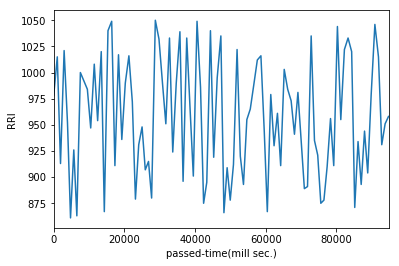

In [37]:
# x軸に総合経過時間，y軸にRRIをとって変動波を作成して，プロットする

# 累積和＝経過時間となる（ただし最初は0であってほしいので，そうなるように処理する）
x = RRI.cumsum()-RRI[0]
y = RRI
#print(x)

plt.plot(x, y)
plt.xlim(0, x[-1])
plt.xlabel("passed-time(mill sec.)")
plt.ylabel("RRI")

In [43]:
# lombscargle関数でPSDを求める

# 周波数帯域
LF_MIN = 0.05
LF_MAX = 0.15
HF_MIN = 0.15
HF_MAX = 0.4

# 検出点の数
# 増やしても結果は大きく変わらないので，計算コストを考えるとこれくらいが妥当
NOUT = 10

# 検出したい周波数帯域
F = np.linspace(LF_MIN, HF_MAX, NOUT)

# LFとHFをわけるための敷居値
L = np.where(F<LF_MAX)[0][-1] + 1
print(F, L)

pgram = lombscargle(x, y, F)

# 正規化する
normval = x.shape[0]
pgram = np.sqrt(4*(pgram/normval))

print(pgram)

[ 0.05        0.08888889  0.12777778  0.16666667  0.20555556  0.24444444
  0.28333333  0.32222222  0.36111111  0.4       ] 3
[ 138.40638967   58.1040889   114.80796407  188.7689994   188.40646997
   44.99122122  387.79600849   86.45645128  159.66721728  237.39708793]


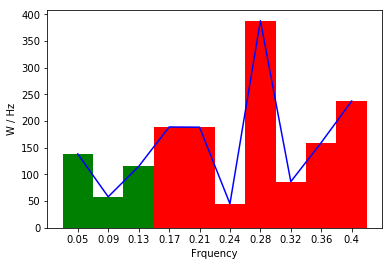

In [44]:
# 計算したPSDをプロットしてみる

plt.plot(range(NOUT), pgram, color="b")

c = []
for i in range(NOUT) :
    if i < L :
        c.append("g")
    else :
        c.append("r")
        
plt.bar(range(NOUT), pgram, width=1.0, tick_label=np.round(F, 2), color=c)

plt.xlabel("Frquency")
plt.ylabel("W / Hz")

In [45]:
# LF/HF比を求める

# PSDの平均を求める
# 積算なのか平均なのかは諸説あり？
if 0 :
    M_lf = np.mean(pgram[:L])
    M_hf = np.mean(pgram[L:])
else :
    M_lf = np.sum(pgram[:L])
    M_hf = np.sum(pgram[L:])
print(M_lf , M_hf)

total = M_lf + M_hf
lf = M_lf / total
hf =M_hf / total

print(lf, hf)
print("LF/HF = %s" %(lf/hf))

311.318442639 1293.48345557
0.193991821039 0.806008178961
LF/HF = 0.240682199142


(0.0, 1.0)

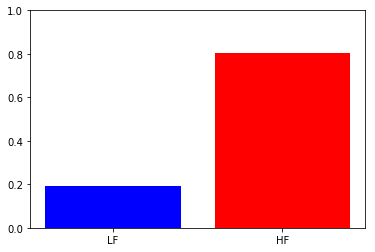

In [46]:
# LFとHFをプロットしてみる

plt.bar([1, 2], [lf, hf], tick_label=["LF", "HF"], color=["b", "r"])
plt.ylim(0.0, 1.0)